In [13]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*10
presets = 'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = ["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

use_groups = False
n_groups = 8

auto_stack = True
num_stack_levels = 1
num_bag_folds = 0
if auto_stack:
    num_stack_levels = None
    num_bag_folds = None

use_tune_data = False
use_test_data = True
tune_and_test_length = 24*30*3 # 3 months from end, this changes the evaluations for only test
holdout_frac = None
use_bag_holdout = False # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = 'sample_weight' #None
weight_evaluation = True #False
sample_weight_estimated = 1 # this changes evaluations for test and tune WTF, cant find a fix

run_analysis = False

In [14]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0].copy()
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")

    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = sample_weight_estimated
    X_test["sample_weight"] = sample_weight_estimated

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])

    # fill missng sample_weight with 3
    #X_train["sample_weight"] = X_train["sample_weight"].fillna(0)
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [15]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y'], inplace=True)


for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

print(X_train.head())




if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())





to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
ds                                                                   
2019-06-02 22:00:00                       7.7                1.230   
2019-06-02 23:00:00                       7.7                1.225   
2019-06-03 00:00:00                       7.7                1.221   
2019-06-03 01:00:00                       8.2                1.218   
2019-06-03 02:00:00                       8.8                1.219   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
ds                                                                 
2019-06-02 22:00:00           1744.900024               0.000000   
2019-06-02 23:00:00           1703.599976               0.000000   
2019-06-03 00:00:00           1668.099976               0.000000   
2019-06-03 01:00:00           1388.400024               0.000000   
2019-06-03 02:00:00           1108.500000            6546.899902   

                     clear_sky_r

In [16]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
test_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    test_set = test_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    test_set = test_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])


def normalize_sample_weights(df):
    df["sample_weight"] = df["sample_weight"] / df["sample_weight"].sum() * df.shape[0]
    return df

tuning_data = None
if use_tune_data:
    train_data = train_set
    if use_test_data:
        # split test_set in half, use first half for tuning
        tuning_data, test_data = [], []
        for loc in locations:
            loc_test_set = test_set[test_set["location"] == loc]
            loc_tuning_data = loc_test_set.iloc[:len(loc_test_set)//2]
            loc_test_data = loc_test_set.iloc[len(loc_test_set)//2:]
            tuning_data.append(loc_tuning_data)
            test_data.append(loc_test_data)
        tuning_data = pd.concat(tuning_data)
        test_data = pd.concat(test_data)
        print("Shapes of tuning and test", tuning_data.shape[0], test_data.shape[0], tuning_data.shape[0] + test_data.shape[0])

    else:
        tuning_data = test_set
        print("Shape of tuning", tuning_data.shape[0])
    
    # ensure sample weights for your tuning data sum to the number of rows in the tuning data.
    tuning_data = normalize_sample_weights(tuning_data)

    
else:
    if use_test_data:
        train_data = train_set
        test_data = test_set
        print("Shape of test", test_data.shape[0])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
train_data = normalize_sample_weights(train_data)
if use_test_data:
    test_data = normalize_sample_weights(test_data)

Loaded data from: X_train_raw.csv | Columns = 50 / 50 | Rows = 92951 -> 92951


Shape of test 5791


In [17]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

In [18]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y")

# Starting

In [19]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 79
Now creating submission number: 80
New filename: submission_80_jorge


In [20]:
def fit_predictor():
    print("Training model for all locations...")
    # sum of sample weights, and number of rows, for both train and tune data and test data
    print("Train data sample weight sum:", train_data["sample_weight"].sum())
    print("Train data number of rows:", train_data.shape[0])
    if use_tune_data:
        print("Tune data sample weight sum:", tuning_data["sample_weight"].sum())
        print("Tune data number of rows:", tuning_data.shape[0])
    if use_test_data:
        print("Test data sample weight sum:", test_data["sample_weight"].sum())
        print("Test data number of rows:", test_data.shape[0])

    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}",  # Removed location from the filename
        sample_weight=sample_weight, 
        weight_evaluation=weight_evaluation, 
        groups="group" if use_groups else None,
    ).fit(
        train_data=train_data,
        time_limit=time_limit, 
        num_stack_levels=num_stack_levels, 
        num_bag_folds=num_bag_folds if not use_groups else 2, 
        tuning_data=tuning_data if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_test_data:
        # Removed location-based filtering
        t = test_data  
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor


predictor = fit_predictor()
predictors = [predictor, predictor, predictor]



Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "AutogluonModels/submission_80_jorge/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   15.50 GB / 494.38 GB (3.1%)
Train Data Rows:    87160
Train Data Columns: 48
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 288.17846, 766.38726)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You ma

Training model for all locations...
Train data sample weight sum: 87160.0
Train data number of rows: 87160
Test data sample weight sum: 5791.0
Test data number of rows: 5791


			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 43 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])    :  3 | ['is_estimated', 'hour', 'year']
		('object', []) :  1 | ['location']
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  :  1 | ['location']
		('float', [])     : 41 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])  

[1000]	valid_set's l1: 88.3859
[2000]	valid_set's l1: 84.2741
[3000]	valid_set's l1: 82.6389
[4000]	valid_set's l1: 81.475


	Ran out of time, early stopping on iteration 4136. Best iteration is:
	[4123]	valid_set's l1: 81.3727
	-81.3727	 = Validation score   (-mean_absolute_error)
	35.09s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 179.63s of the -1.32s of remaining time.
	-81.3727	 = Validation score   (-mean_absolute_error)
	0.06s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 181.47s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_80_jorge/")
Evaluation: mean_absolute_error on test data: -100.26762260989268
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -100.26762260989268,
    "root_mean_squared_error": -267.34906612597484,
    "mean_squared_error": -71475.52315843088,
    "r2": 0.8

Evaluation on test data:
-100.26762260989268


# Submit

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 50 / 50 | Rows = 92951 -> 92951
Loaded data from: X_test_raw.csv | Columns = 49 / 49 | Rows = 2160 -> 2160


In [22]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [23]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    past_pred = predictors[i].predict(train_data_with_dates[train_data_with_dates["location"] == loc])
    train_data_with_dates.loc[train_data_with_dates["location"] == loc, "prediction"] = past_pred
    

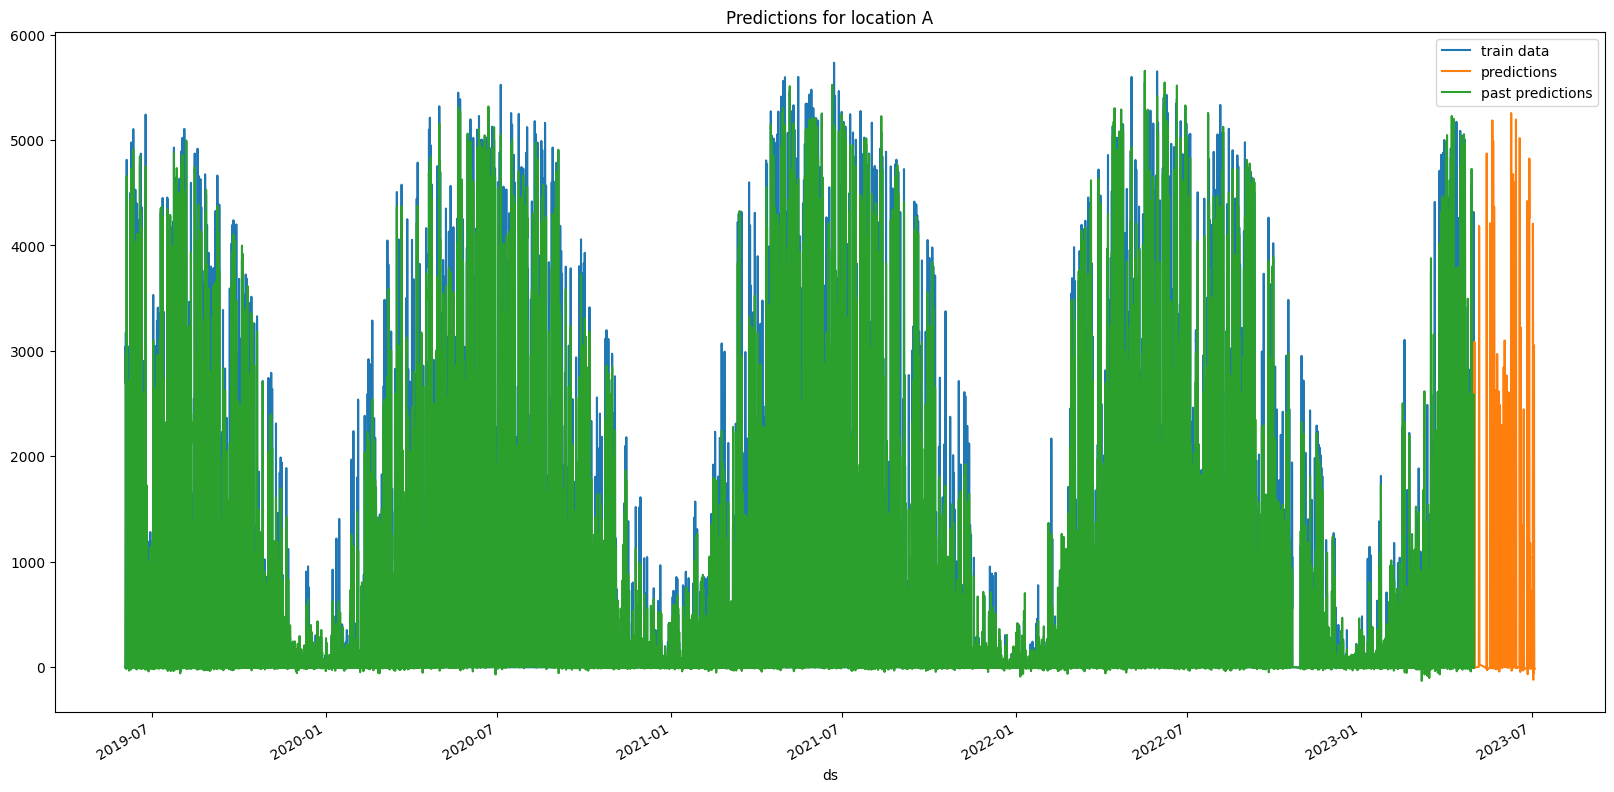

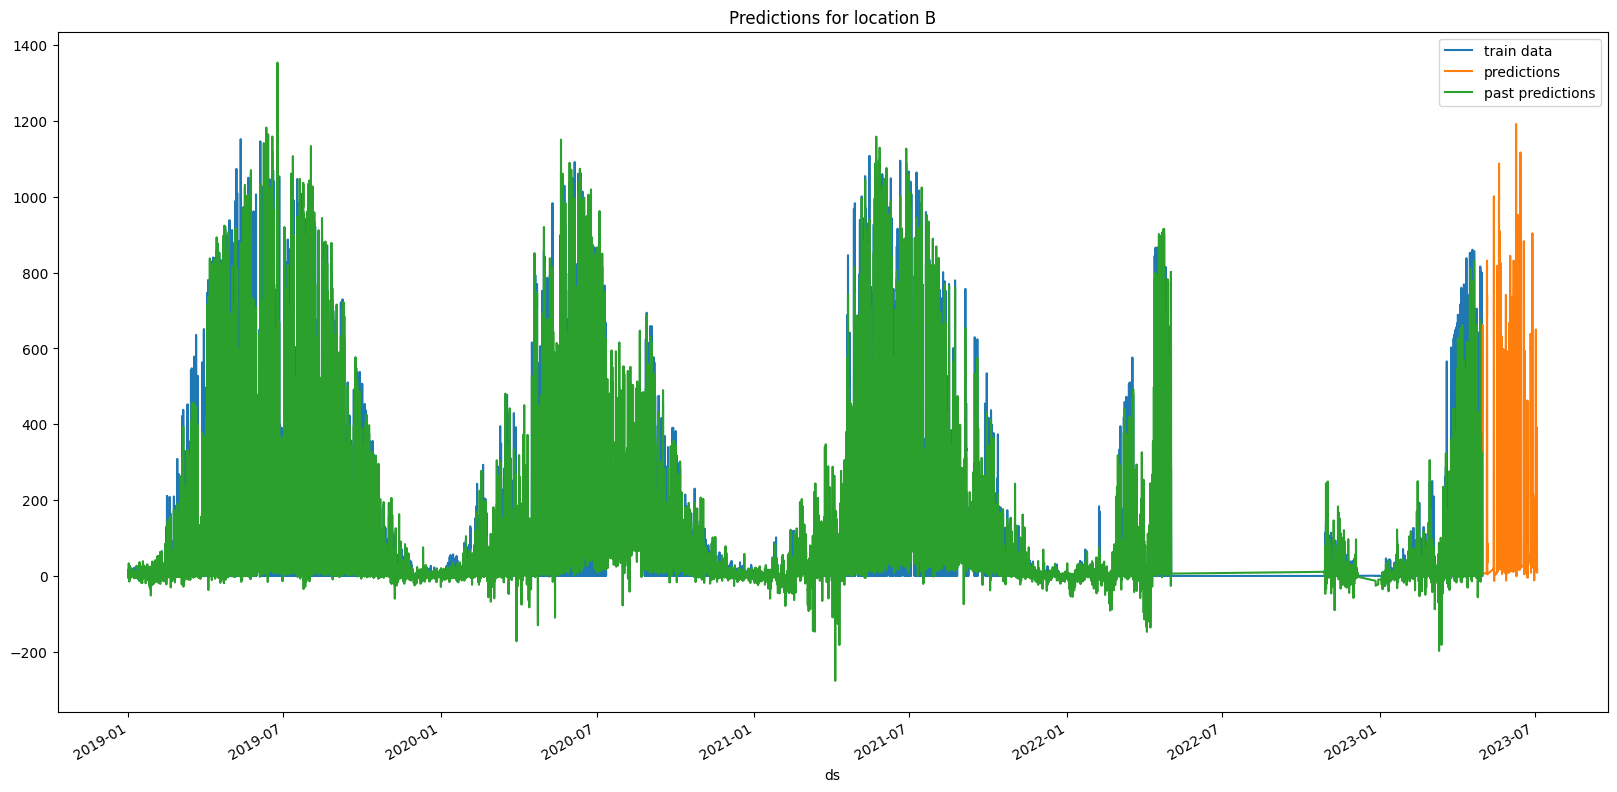

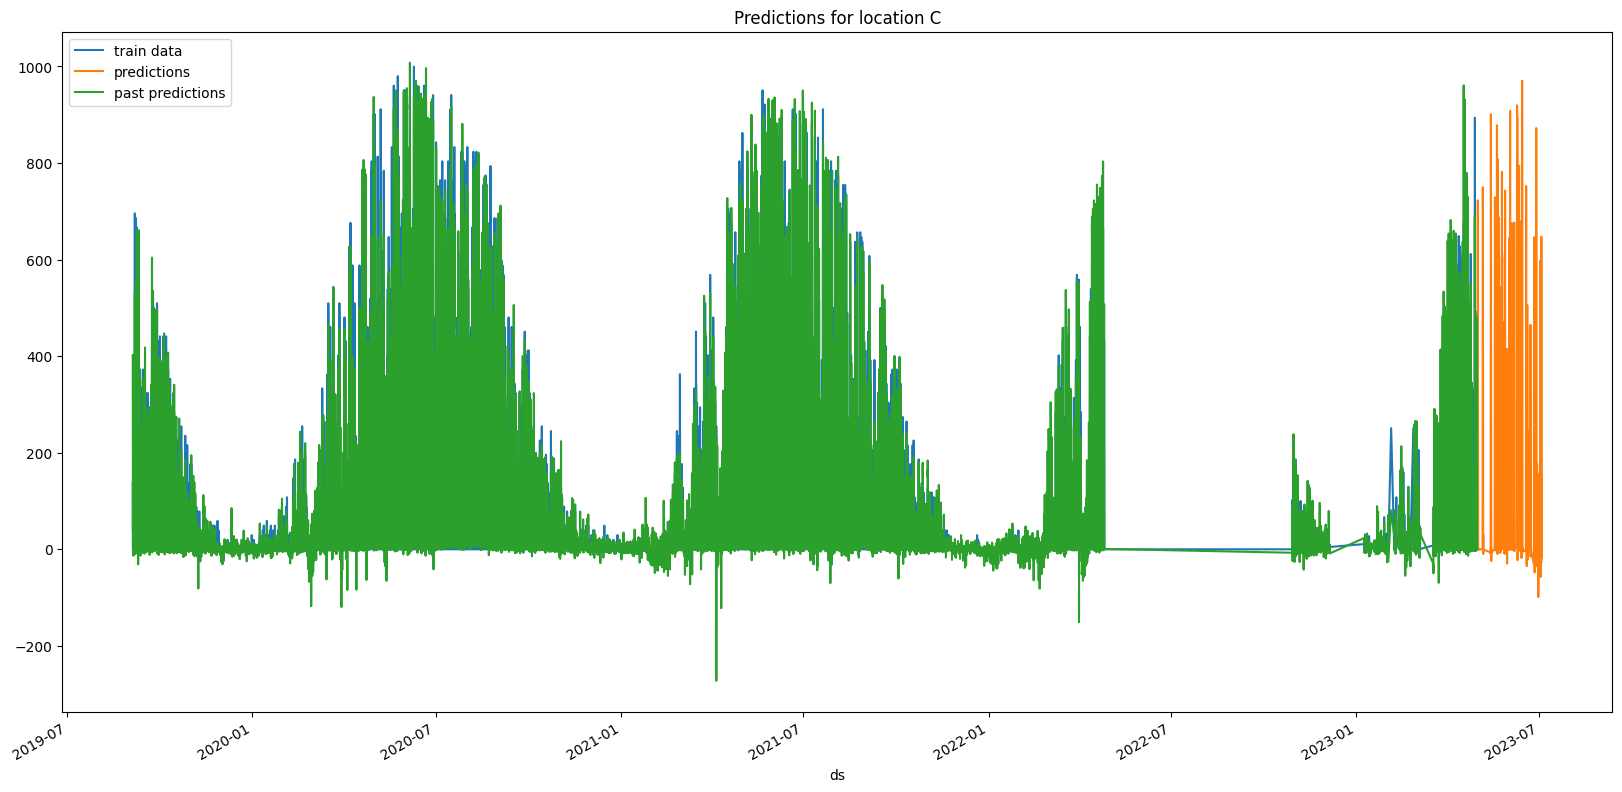

In [24]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [25]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,-1.224258
1,1,-0.166361
2,2,5.063942
3,3,50.107296
4,4,409.815216
...,...,...
715,2155,15.399491
716,2156,2.158085
717,2157,-3.174377
718,2158,-17.467293


In [26]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_80_jorge.csv
jall1a


In [27]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [28]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_80_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_80_jorge_files/notebook_pdfs
[NbConvertApp] Writing 176286 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 361211 bytes to notebook_pdfs/submission_80_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_80_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [29]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'sample_weight', 'prediction']
Computing feature importance via permutation shuffling for 47 features using 4394 rows with 10 shuffle sets... Time limit: 600s...
	136.82s	= Expected runtime (13.68s per shuffle set)
	73.71s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,127.356060,2.155207,9.153931e-18,10,129.570941,125.141179
clear_sky_rad:W,67.612065,1.753923,4.272110e-16,10,69.414552,65.809579
diffuse_rad:W,33.843488,1.435227,3.547948e-14,10,35.318454,32.368522
direct_rad_1h:J,30.432588,0.726762,2.029591e-16,10,31.179473,29.685704
hour,28.206363,2.046513,4.399970e-12,10,30.309540,26.103185
sun_elevation:d,25.838884,0.990536,1.431736e-14,10,26.856847,24.820921
sun_azimuth:d,13.758951,1.793804,8.233255e-10,10,15.602423,11.915480
clear_sky_energy_1h:J,12.167778,0.539049,5.253596e-14,10,12.721753,11.613804
effective_cloud_cover:p,11.025089,0.866490,9.003742e-12,10,11.915571,10.134608
total_cloud_cover:p,10.109163,0.742880,4.932417e-12,10,10.872612,9.345713


In [30]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'sample_weight', 'prediction']
Computing feature importance via permutation shuffling for 47 features using 5000 rows with 10 shuffle sets... Time limit: 600s...
	112.58s	= Expected runtime (11.26s per shuffle set)
	101.03s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,245.003542,9.276562,1.280803e-14,10,254.536956,235.470128
clear_sky_rad:W,207.242867,5.577449,5.946855e-16,10,212.974746,201.510988
diffuse_rad:W,78.826373,2.927926,1.078036e-14,10,81.835369,75.817378
direct_rad_1h:J,70.465107,2.878445,2.534127e-14,10,73.423251,67.506963
sun_elevation:d,59.736939,1.776386,1.459072e-15,10,61.562510,57.911368
clear_sky_energy_1h:J,59.169604,2.489713,3.307256e-14,10,61.728253,56.610955
hour,49.710655,2.160608,4.425494e-14,10,51.931087,47.490223
sun_azimuth:d,35.985237,2.001179,4.049092e-13,10,38.041825,33.928648
cloud_base_agl:m,34.596400,1.626751,8.972640e-14,10,36.268193,32.924608
ceiling_height_agl:m,33.601294,1.335829,1.985499e-14,10,34.974110,32.228478


In [31]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_80_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_80_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 176430 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 361238 bytes to notebook_pdfs/submission_80_jorge_with_feature_importance.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_80_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [32]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])